# Face detection ProtoNet

This section onward, the aim is to modify the existing ProtoNet to act as a face detection network. The main idea is to push it somewhat toward the construction of a Siamese Network, in the sense that there is a reference embedding compared to a singular query, but without the construction of the twin network. 


The new ProtoNet will work as follows: Create a prototype of the face by using the average of the embedding of the support set. The embeddding of the query is then compared to the prototype and then if similarity is above a certain threshold, the face is classified into the same class. 

Some expected differences in the model are: 

1. There will be only one support class. Therefore, the model wll default into a K-shot binary classifier

2. The binary classifier behaviour will entail using a sigmoid function instead of softmax, which might cause unexpected things while training the model. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import os
import cv2
import time

import tqdm
from tqdm.notebook import trange

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data extraction

This section just deals with drawing the necessary images from the necessary directories. 

Initially, I had written code within this notebook itself to extract data from the respective directories. However, as I started training the model on more than one dataset, I decided to shift those functions to seperate files, for ease of operability


In [6]:
import omni_data
import lfw_data
import yt_data

## Data balancing 

Data balancing in this network is very important since it is imperative that we have a dataset that consists of more or less equal number of positive and negative samples within the data to avoid a skew toward either side that might affect the inference of the model. 

At this point, I can think of 2 approaches: 
1. Use a random choice to decide whether the query should be from same class or not, and then correspondingly choose a random images from the available images. 

2. Create a balanced sample of matching and non-matching support+query image sets from the existing set of images, and then use that dataset for training step. 

The first one seems easier to implement, but logically, the second one seems like it might get a better result. 
 
And also, for the sake of ease and future compilability, we shall explicitly initialise the model with the K, not infer it from the sample.
 

In [4]:
def extract_sample(datax, datay, n_support, n_query = 1):
    
    cls = np.random.choice(np.unique(datay))
    datax_cls = datax[datay==cls]
    datax_ncls = datax[datay!=cls] 
        
    perm = np.random.permutation(datax_cls)
    support = tf.image.convert_image_dtype(perm[:n_support], dtype=tf.float32)
    
    k = n_query//2 #k is number of matching samples
    m = n_query-k
    
    k_ind = np.random.randint(datax_cls.shape[0],size = k)
    m_ind = np.random.randint(datax_ncls.shape[0],size = m)
    
    query = np.concatenate((datax_cls[k_ind],datax_ncls[m_ind]), axis = 0)
    query = tf.image.convert_image_dtype(query, dtype=tf.float32)
    
    label = tf.concat([tf.ones((k,1)),tf.zeros((m,1))],0)
    
    sample = {'support': support,
              'query': query,
              'label': label}
    
    return sample

In [5]:
def display_sample(sample):
    
    ns = sample['support'].shape[0]
    nq = sample['query'].shape[0]
    
    for i,img in enumerate(sample['support']):
        plt.subplot(1,ns,i+1)
        plt.imshow(img)
        plt.title("Support set")

    plt.show()

    for i,img in enumerate(sample['query']):
        plt.subplot(nq//3+1,min(3,nq),i+1)
        plt.imshow(img)
        plt.title("Query set")
    plt.show()
    

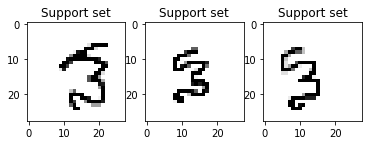

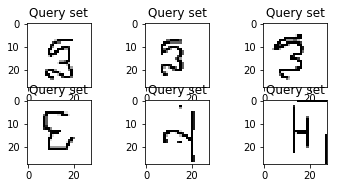

Label is : [[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [6]:
sample = extract_sample(trainx,trainy,3,6)

display_sample(sample)
print("Label is :",sample['label'].numpy())

#plt.imshow(sample['images'][0][0])

## Building the model 

The model is slightly different as it is a binary classifier now. 

Further descriptions once the model has actually been built 


In [9]:
def convolution_block( n_filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D( filters = n_filters, kernel_size = 3, padding = 'same'), 
        tf.keras.layers.BatchNormalization(-1), 
        tf.keras.layers.ReLU(), 
        tf.keras.layers.MaxPool2D((2,2))
    ])


class FaceNet(tf.keras.Model):
    
    def __init__(self, k, n_filters, output_dim):
        
        '''
        Args:
        k: The number of examples in the support set
        n_filters = number of filters in convolutional layers
        output_dim = dimensions of output 
        
        '''
        super(FaceNet, self).__init__()
        
        self.k = k
        self.encoder = tf.keras.Sequential([
            convolution_block(n_filters), 
            convolution_block(n_filters), 
            convolution_block(n_filters), 
            convolution_block(output_dim),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(output_dim)
        ])
        
        
    def encode(self, sample):
        
        '''
        Args: 
        sample: object returned by extract_sample()
                {'support': support set, 'query': query image }
        Returns:
        embedding of the support set and query images
        '''
        support = sample['support']
        query = sample['query']
        x = tf.concat([ support, query], axis =0) # Data is now in 4-D form
        embedding = self.encoder(x)
        return embedding
    
    def call(self, sample):
        
        out = self.encode(sample)
        support = out[:self.k]
        proto = tf.math.reduce_mean(support, 0, keepdims=True)
        query = out[self.k:]
        
        distances = self.euclidian_dist(query, proto)
        probs = tf.nn.sigmoid(-distances+10) 
        y_hat = tf.cast((probs>0.85), tf.float32)
        
        return tf.squeeze(y_hat).numpy()
    
    def euclidian_dist(self, x , y):
    
        ''' This calculates the euclidian distance between two 2-D vectors. 
        The first dimension need not be equal for the vectors, but the second has to be 
    
        Args:
        x: dimension (k, len) vector (considered as query)
        y: dimension (n, len) vector (considered as prototype) 
        Returns: 
        distances: vector of (k,n) dimension, representing distance of each query from each prototype'''
    
        k, x_len = x.shape
        n, y_len = y.shape
    
        assert x_len == y_len, "Length of query and prototype embeddings dont match"
    
        x = tf.tile( x,(1,n) )
        y = tf.tile( y,(k,1) )
        distances = tf.reduce_sum(tf.math.pow(x-y,2), axis=1, keepdims = True)
        return distances
    
    def forward_loss(self, sample):
        
        out = self.encode(sample)
        support = out[:self.k]
        proto = tf.math.reduce_mean(support, 0, keepdims=True)
        query = out[self.k:]
        
        distances = self.euclidian_dist(query, proto)
        
        # Computing sigmoid, instead of softmax, and adding a bias value to the distance 
        # as the minimum value of distance that euclidian_dist can give is 0. 
        
        probs = tf.nn.sigmoid(-distances+10)   
        bin_loss = tf.keras.losses.binary_crossentropy(sample['label'],probs)
        loss = tf.math.reduce_mean(bin_loss)
        
        # Since this is aimed at a biometric system, I am assuming that it is a match only above 0.85 probability
        y_hat = tf.cast((probs>0.85), tf.float32)
        accuracy = tf.math.reduce_mean(tf.cast(y_hat==sample['label'], dtype=tf.float32))
        
        return loss, {'loss': loss.numpy(), 
                'accuracy': accuracy.numpy()}
    
    
    def save(self,path):
        self.save_weights(path)
        
    def load(self,path):
        self.encoder(tf.zeros([1,28,28,3]))
        self.load_weights(path)


In [10]:
model = FaceNet(3,64,64)
sample = extract_sample(trainx,trainy,3,5)

out = model(sample)
print(out.shape)
proto = tf.math.reduce_mean(out[:3],0,keepdims=True)
query = out[3:]

model.forward_loss(sample)

(5,)


(<tf.Tensor: shape=(), dtype=float32, numpy=5.983979>,
 {'loss': 5.983979, 'accuracy': 0.4})

## Training the model 



In [3]:
%%time 

trainx, trainy = read_images('images_background')
testx, testy = read_images('images_evaluation')

print(f"Training set contains {trainx.shape[0]} images")
print(f"Testing set contains {testx.shape[0]} images \n")

NameError: name 'trainx_o' is not defined

In [11]:
def train (model, init_lr, train_x, train_y, n_support, n_query, epochs, epoch_size):
    
    """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      epochs (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
    
    lr  = init_lr
    optimizer = tf.keras.optimizers.Adam(lr)
    epoch = 0
    
    while epoch < epochs  :
        r_loss = 0.0
        r_acc = 0.0
        
        for episode in trange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(train_x, train_y, n_support, n_query)
            
            with tf.GradientTape() as tape:
                loss, out = model.forward_loss(sample)
        
            grads = tape.gradient(loss, model.trainable_variables)
            
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            r_loss += out['loss']
            r_acc += out['accuracy']
            
        epoch_loss = r_loss / epoch_size
        epoch_acc = r_acc / epoch_size
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        lr = lr/2

In [13]:
%%time

model = FaceNet(3,64,64)
checkpoint_file = 'ProtoNet'+ time.strftime("%d%m_%I%M")+'.weights'

n_support = 3
n_query = 20

train_x = trainx
train_y = trainy

max_epoch = 4
epoch_size = 2000

train(model, 0.001, train_x, train_y, n_support, n_query, max_epoch, epoch_size)

model.save(f'model_weights/{checkpoint_file}')


Epoch 1 -- Loss: 0.3309 Acc: 0.9114



Epoch 2 -- Loss: 0.1554 Acc: 0.9464



Epoch 3 -- Loss: 0.1305 Acc: 0.9555



Epoch 4 -- Loss: 0.1114 Acc: 0.9596
CPU times: user 9min 47s, sys: 2min 6s, total: 11min 54s
Wall time: 11min 51s


## Testing the model

This is just a very brief check to see if the model is indeed working well on the test set. Do now worry about over-fitting as this model is just a sample to test on a simple dataset. 

In [14]:
acc = 0
for _ in trange(2000,desc="Testing model"):
    
    sample = extract_sample(testx,testy,3,20)
    loss,output = model.forward_loss(sample)
    acc += output['accuracy']
    
print("Test accuracy: ",acc/2000)


Test accuracy:  0.9578249953687191


The cell below shows an example. 

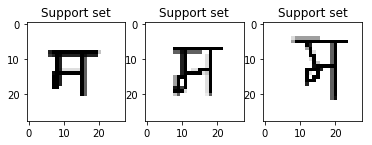

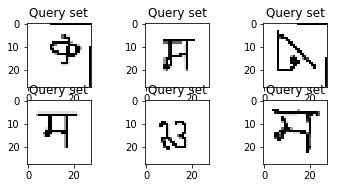

The models inference is: [False  True False  True False  True]


In [16]:
sample = extract_sample(testx,testy,3,6)
sample['query'] = tf.random.shuffle(sample['query'])
display_sample(sample)

y_hat = model(sample)
print(f"The models inference is: {(y_hat==1.)}")
      
      

## LFW dataset 

In [ ]:
%%time 

## getting training and testing datasets

x,y = load_data('LFW', min_num=3)

trainx,trainy,testx,testy = split_dataset(x,y,weight=0.7)


In [ ]:
sample = extract_sample(trainx,trainy,3,3)

display_sample(sample)

In [ ]:
model = FaceNet(3,64,64)
sample = extract_sample(trainx,trainy,3,5)

model.forward_loss(sample)

In [ ]:

model = FaceNet(3,64,64)
checkpoint_file = 'ProtoNet_FLW'+ time.strftime("%d%m_%I%M")+'.weights'

n_support = 3
n_query = 20

train_x = trainx
train_y = trainy

max_epoch = 2
epoch_size = 2000

train(model, 0.001, train_x, train_y, n_support, n_query, max_epoch, epoch_size)

model.save(f'model_weights/{checkpoint_file}')

## YouTube faces dataset 

In [ ]:
import numpy as np 
import cv2
import multiprocessing as mp
import os

def read_faces(path, label, min_num=1):
    
    data = np.load(path)
    imgs = np.transpose(data['colorImages'], (3,0,1,2))
    
    if imgs.shape[0]<min_num:
        return np.empty(0),np.empty(0)
    
    imgs = np.array([cv2.resize(img, (125,125)) for img in imgs])
    label = np.array([label for i in range(imgs.shape[0])])
    
    return imgs,label

def load_data(base_directory, min_num=1):

    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_faces,
                          args=(
                              base_directory + '/' + file, '_'.join(file.split('_')[:-1]), min_num
                              )) for file in os.listdir(base_directory)]
    pool.close()
    
    for result in results:
        if len(result[0])==0:
            continue
        elif datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay,result[1]])
            
    return datax, datay
    

In [ ]:
%%time

import yt_data

datax,datay = yt_data.load_data('YTF',min_num=3)

In [ ]:
sample = extract_sample(datax,datay,3,6)
display_sample(sample)